In [ ]:
!pip install -q transformers datasets scikit-learn xgboost


In [ ]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Enable inline plotting
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments


In [ ]:
df = pd.read_csv("amazon.csv")
df = df.dropna(subset=['review_content', 'rating'])


**Sentiment Analysis on Product Reviews**

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@w+|\#','', text)  # Remove mentions and hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters and digits
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return " ".join(tokens)

df["clean_review"] = df["review_content"].apply(clean_text)
df[["review_content", "clean_review"]].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,review_content,clean_review
0,Looks durable Charging is fine tooNo complains...,looks durable charging fine toono complainscha...
1,I ordered this cable to connect my phone to An...,ordered cable connect phone android auto car c...
2,"Not quite durable and sturdy,https://m.media-a...",quite durable sturdy good nice productworking ...
3,"Good product,long wire,Charges good,Nice,I bou...",good productlong wirecharges goodnicei bought ...
4,"Bought this instead of original apple, does th...",bought instead original apple work rs fast app...


In [ ]:
!pip install transformers --quiet


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

model_name = "nlptown/bert-base-multilingual-uncased-sentiment"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


Device set to use cpu


In [ ]:
# take sample
sample_reviews = df["review_content"].dropna()
sample_reviews = sample_reviews[sample_reviews.str.len() < 512].sample(5, random_state=42).tolist()

for review in sample_reviews:
    result = sentiment_pipeline(review[:512])[0]
    print(f"📝 Review: {review}")
    print(f"➡️ Sentiment: {result['label']} (Confidence: {round(result['score'], 2)})\n")


📝 Review: The base Unit is rather flimsy?? Could have been better designed???,Nice,you should absolutly goo for it,Good and satisfactory.,After 2 or 3 month use it started leaking.please mind this before purchase,Cord length is too short.,Nice Product than you Amazon for prompt delivery and nice product,Bought it for Rs 699 in deals. Worth for money.
➡️ Sentiment: 2 stars (Confidence: 0.49)

📝 Review: Work perfectly and amazingly.Must buy for cloth lint,It is so convenient.... It clean so easily and easy to remove but the problem is that it consumes much more time then I expected,https://m.media-amazon.com/images/W/WEBP_402378-T1/images/I/818fjULV22L._SY88.jpg,Works good. Wire is also not very  short,Very nice, easy to use,good at this price.,Product is good,Easy to use, value for money, easy to remove.
➡️ Sentiment: 4 stars (Confidence: 0.6)

📝 Review: Overall good purchase but it smells if you use for upto first week. So keep it in sun later use it otherwise you clothes may smell the

In [ ]:
#rateing the review
df["sentiment_bert_stars"] = df["review_content"].fillna("").apply(
    lambda x: sentiment_pipeline(x[:512])[0]["label"]
)

df[["review_content", "sentiment_bert_stars"]].head()


,review_content,sentiment_bert_stars
0,Looks durable Charging is fine tooNo complains...,4 stars
1,I ordered this cable to connect my phone to An...,4 stars
2,"Not quite durable and sturdy,https://m.media-a...",3 stars
3,"Good product,long wire,Charges good,Nice,I bou...",4 stars
4,"Bought this instead of original apple, does th...",3 stars


In [ ]:
def map_sentiment(star_label):
    stars = int(star_label.split()[0])
    if stars <= 2:
        return "NEGATIVE"
    elif stars == 3:
        return "NEUTRAL"
    else:
        return "POSITIVE"

df["sentiment_label"] = df["sentiment_bert_stars"].apply(map_sentiment)


In [ ]:
df[["review_content", "sentiment_bert_stars", "sentiment_label"]].head()


,review_content,sentiment_bert_stars,sentiment_label
0,Looks durable Charging is fine tooNo complains...,4 stars,POSITIVE
1,I ordered this cable to connect my phone to An...,4 stars,POSITIVE
2,"Not quite durable and sturdy,https://m.media-a...",3 stars,NEUTRAL
3,"Good product,long wire,Charges good,Nice,I bou...",4 stars,POSITIVE
4,"Bought this instead of original apple, does th...",3 stars,NEUTRAL


**Avg User Price**

In [ ]:
# Remove the currency symbol '₹' and convert the price to a float
df["discounted_price_numeric"] = df["discounted_price"].replace("₹", "", regex=True).str.replace(",", "").astype(float)

# Ensure that the 'user_id' column contains only one user per row (it seems to contain multiple IDs separated by commas)
# So we need to "explode" this column to repeat the row for each user

df = df.assign(user_id=df["user_id"].str.split(",")).explode("user_id")

# Recalculate the average price for each user
user_price_pref = df.groupby("user_id")["discounted_price_numeric"].mean().reset_index()
user_price_pref.rename(columns={"discounted_price_numeric": "avg_user_price"}, inplace=True)

# Merge the average price back into the original dataset
df = df.merge(user_price_pref, on="user_id", how="left")


In [ ]:
# Price is within ±35% of the user's average price
df["is_price_within_relative_range"] = (
    (df["discounted_price_numeric"] >= df["avg_user_price"] * 0.65) &
    (df["discounted_price_numeric"] <= df["avg_user_price"] * 1.35)
)

# Preview the results
df[["user_id", "discounted_price_numeric", "avg_user_price", "is_price_within_relative_range"]].head(50)


,user_id,discounted_price_numeric,avg_user_price,is_price_within_relative_range
0,AG3D6O4STAQKAY2UVGEUV46KN35Q,399.00,467.750000,True
1,AHMY5CWJMMK5BJRBBSNLYT3ONILA,399.00,467.750000,True
2,AHCTC6ULH4XB6YHDY6PCH2R772LQ,399.00,467.750000,True
3,AGYHHIERNXKA6P5T7CZLXKVPT7IQ,399.00,467.750000,True
4,AG4OGOFWXJZTQ2HKYIOCOY3KXF2Q,399.00,467.750000,True
5,AENGU523SXMOS7JPDTW52PNNVWGQ,399.00,467.750000,True
6,AEQJHCVTNINBS4FKTBGQRQTGTE5Q,399.00,467.750000,True
7,AFC3FFC5PKFF5PMA52S3VCHOZ5FQ,399.00,448.444444,True
8,AECPFYFQVRUWC3KGNLJIOREFP5LQ,199.00,212.000000,True
9,AGYYVPDD7YG7FYNBXNGXZJT525AQ,199.00,213.285714,True


**Product Recommendation System**


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# Load data
df = pd.read_csv("amazon.csv")

# Data cleaning
df['product_name'] = df['product_name'].astype(str)
df['category'] = df['category'].astype(str)
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df = df.dropna(subset=['rating']).reset_index(drop=True)

# TF-IDF + Nearest Neighbors setup (used only if needed)
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['product_name'])
model = NearestNeighbors(n_neighbors=15, metric='cosine')
model.fit(tfidf_matrix)

# Recommendation function
def recommend_products_by_name_and_category(product_name, top_n_each=5):
    product_name_lower = product_name.lower()

    # Step 1: Get top products by name match
    name_matches = df[df['product_name'].str.lower().str.contains(product_name_lower)].copy()
    name_matches = name_matches.sort_values(by='rating', ascending=False).head(top_n_each)

    # Step 2: If there are matches, get category of top product and recommend similar category products
    if not name_matches.empty:
        first_category = name_matches.iloc[0]['category']
        category_matches = df[
            (df['category'] == first_category) &
            (~df['product_name'].str.lower().str.contains(product_name_lower))
        ].copy()
        category_matches = category_matches.sort_values(by='rating', ascending=False).head(top_n_each)
    else:
        # Optional fallback to TF-IDF (if no product name matches at all)
        tfidf_query = tfidf.transform([product_name_lower])
        distances, indices = model.kneighbors(tfidf_query, n_neighbors=top_n_each + 10)
        similar_products = df.iloc[indices[0]].copy()
        similar_products = similar_products[~similar_products['product_name'].str.lower().str.contains(product_name_lower)]
        name_matches = similar_products.sort_values(by='rating', ascending=False).head(top_n_each)
        category_matches = pd.DataFrame(columns=df.columns)

    # Combine and return final table
    final_df = pd.concat([name_matches, category_matches])
    return final_df[['product_name', 'category', 'rating', 'discounted_price', 'product_link']].reset_index(drop=True)

# Run and display result as a table
recommendations_df = recommend_products_by_name_and_category("usb-c", top_n_each=5)
recommendations_df

,product_name,category,rating,discounted_price,product_link
0,"REDTECH USB-C to Lightning Cable 3.3FT, [Apple...",Computers&Accessories|Accessories&Peripherals|...,5.0,₹249,https://www.amazon.in/REDTECH-Lightning-Certif...
1,Belkin USB C to USB-C Fast Charging Type C Cab...,Computers&Accessories|Accessories&Peripherals|...,4.5,₹599,https://www.amazon.in/Belkin-USB-C-Charging-US...
2,Belkin USB C to USB-C Fast Charging Type C Cab...,Computers&Accessories|Accessories&Peripherals|...,4.5,₹599,https://www.amazon.in/Belkin-USB-C-Charging-US...
3,Amazonbasics Nylon Braided Usb-C To Lightning ...,Computers&Accessories|Accessories&Peripherals|...,4.4,₹899,https://www.amazon.in/AmazonBasics-Apple-Certi...
4,Amazonbasics Nylon Braided Usb-C To Lightning ...,Computers&Accessories|Accessories&Peripherals|...,4.4,₹899,https://www.amazon.in/AmazonBasics-Apple-Certi...
5,Syncwire LTG to USB Cable for Fast Charging Co...,Computers&Accessories|Accessories&Peripherals|...,5.0,₹399,https://www.amazon.in/Syncwire-Cable-Charging-...
6,AmazonBasics USB 2.0 - A-Male to A-Female Exte...,Computers&Accessories|Accessories&Peripherals|...,4.5,₹199,https://www.amazon.in/AmazonBasics-Extension-C...
7,AmazonBasics USB 2.0 Cable - A-Male to B-Male ...,Computers&Accessories|Accessories&Peripherals|...,4.5,₹209,https://www.amazon.in/AmazonBasics-USB-2-0-Cab...
8,Lapster 65W compatible for OnePlus Dash Warp C...,Computers&Accessories|Accessories&Peripherals|...,4.5,₹199,https://www.amazon.in/Lapster-compatible-OnePl...
9,AmazonBasics New Release Nylon USB-A to Lightn...,Computers&Accessories|Accessories&Peripherals|...,4.5,₹999,https://www.amazon.in/AmazonBasics-Nylon-Braid...


**Review Helpfulness Prediction**

In [ ]:
# Convert rating and rating_count to numeric
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
df["rating_count"] = df["rating_count"].str.replace(",", "").astype(float)

# Drop rows with missing review content or rating
df = df.dropna(subset=["review_content", "rating"])

# Add a new column for review length (in number of words)
df["review_length"] = df["review_content"].apply(lambda x: len(str(x).split()))

# Preview key columns
df[["review_content", "rating", "review_length"]].head()


,review_content,rating,review_length
0,Looks durable Charging is fine tooNo complains...,4.2,60
1,I ordered this cable to connect my phone to An...,4.0,201
2,"Not quite durable and sturdy,https://m.media-a...",3.9,13
3,"Good product,long wire,Charges good,Nice,I bou...",4.2,77
4,"Bought this instead of original apple, does th...",4.2,415


In [ ]:
# Rule: A review is considered helpful if it has more than 50 words and a rating >= 4
df["helpful"] = df.apply(lambda row: 1 if row["review_length"] > 50 and row["rating"] >= 4 else 0, axis=1)

# Show the count of helpful vs non-helpful reviews
df["helpful"].value_counts()


,count
helpful,
1,1030
0,434


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Use TF-IDF to convert text into vectors
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df["review_content"])

# Set the labels (helpful or not)
y = df["helpful"]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Print accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.7508532423208191
              precision    recall  f1-score   support

           0       0.70      0.27      0.39        86
           1       0.76      0.95      0.84       207

    accuracy                           0.75       293
   macro avg       0.73      0.61      0.62       293
weighted avg       0.74      0.75      0.71       293



In [ ]:
# Example of a new review to test the model
test_review = ["This cable works perfectly and is very durable. I’ve used it for over a month with no issues at all. Highly recommend it!"]

# Transform the review using the trained vectorizer
test_vector = vectorizer.transform(test_review)

# Predict helpfulness
prediction = model.predict(test_vector)

# Print the result
print("Helpful Review" if prediction[0] == 1 else "Not Helpful Review")


Helpful Review


In [ ]:
# Select 5 random reviews from data
sample_reviews = df.sample(5, random_state=42)

# Transform the review content to TF-IDF vectors
sample_vectors = vectorizer.transform(sample_reviews["review_content"])

# Predict helpfulness
sample_predictions = model.predict(sample_vectors)

# Display each review with the prediction
for i in range(len(sample_reviews)):
    print(f"\nReview {i+1}:\n{sample_reviews.iloc[i]['review_content']}\n")
    print("Prediction:", "Helpful ✅" if sample_predictions[i] == 1 else "Not Helpful ❌")
    print("-" * 80)



Review 1:
Purchased from Amazon for full price under no offers, still beat competitors by Rs.163Order was placed on Thursday 01/12/22, late in the evening at 11 pm.Was to be Delivered on Thursday 08/12/22 but arrived early on Monday 05/12/22 at 10 am.Quite satisfied with the Delivery, Packaging, Condition of the item and also Happy with the early arrival.Along with the Vacuum we received a basic Instruction Manual and Warranty Card.The Invoice was missing from the parcel, so it had to be downloaded from Amazon.To Register your Warranty, you require to scan the Bar Code on the Invoice and WhatsApp the details.Without any delay, excitedly we got to assemble the unit which was a fairly easy task, took approximately 10 minutes, which I guess is ok for the first time while getting familiar with all various attachments etc.First impressions, the Vacuum itself looks sturdy built wise, but some attachments could be a little stronger. Especially, the extension pipes could be Stainless Steel sa

<ipython-input-61-8ca179eb6a44>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["helpful"], palette="Set1")


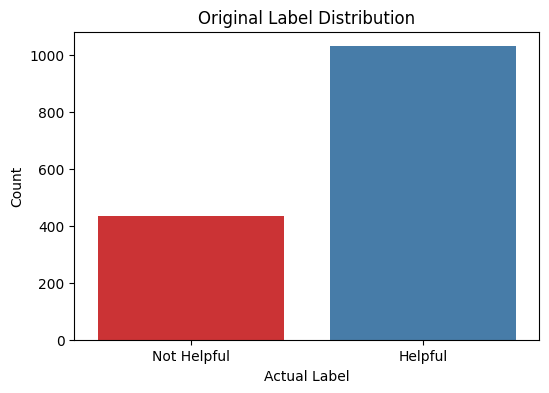

In [ ]:
# Original class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df["helpful"], palette="Set1")
plt.xticks([0, 1], ["Not Helpful", "Helpful"])
plt.title("Original Label Distribution")
plt.xlabel("Actual Label")
plt.ylabel("Count")
plt.show()
